In [6]:
%load_ext autoreload
%autoreload 2


import math
import pandas as pd
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt

from spectralconvolutions import*
from utilsSimpleConv2D import*
#from SpectralLayer import*

from tensorflow.keras.layers import Layer, Dense
from typing import Tuple,List,Any,Dict


## Data

In [7]:
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()


x_train, x_test=x_train.reshape(-1,28,28,1), x_test.reshape(-1,28,28,1)

x_train, x_test = x_train / 255.0, x_test / 255.0

flat_train = np.reshape(x_train, [x_train.shape[0], 28 * 28])
flat_test = np.reshape(x_test, [x_test.shape[0], 28 * 28])

## parameters

In [9]:
epochs = 10
batch_size=200

use_bias=False
learning_rate=0.03
activation=None
kernel_size=3
use_bias=False


parameters={ "use_lambda_out":False,
              "use_lambda_in":False,
                "use_encode":False,
                 "use_decode":False,
                 "trainable_omega_diag":True,
                 "trainable_omega_triu":False,
                 "trainable_omega_tril":False,
                 "kernel_initializer":"glorot_uniform"
           }


In [10]:
## Model

In [11]:
model= tf.keras.Sequential()
model.add(tf.keras.layers.Input(shape=(28,28,1)))


model.add(SpectralConv2D_T(3,kernel_size=3,strides=1,use_bias=use_bias,activation="relu",**parameters))

model.add(tf.keras.layers.MaxPooling2D((2,2))) 


model.add(tf.keras.layers.Flatten())  


model.add(Dense(1000,use_bias=use_bias,activation=activation))
model.add(Dense(10, use_bias=use_bias, activation='softmax'))

opt = tf.keras.optimizers.Adam(learning_rate=learning_rate)
model.compile(optimizer=opt, loss='sparse_categorical_crossentropy',metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 spectral_conv2d_t (Spectra  (None, 26, 26, 3)         9         
 lConv2D_T)                                                      
                                                                 
 max_pooling2d (MaxPooling2  (None, 13, 13, 3)         0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 507)               0         
                                                                 
 dense (Dense)               (None, 1000)              507000    
                                                                 
 dense_1 (Dense)             (None, 10)                10000     
                                                                 
Total params: 517009 (1.97 MB)
Trainable params: 517009 

In [77]:
def get_accuracy(name_file="SpecConv2dClassique",i=1):
    with open(f"Data{i}/{name_file}/{name_file}.csv", "r") as f:
        data=pd.read_csv(f, sep=",", header=0)
    try:
        data.set_index('N', inplace=True)
    except:
        data.set_index('S', inplace=True)
    return data

In [81]:
def extract_accuracy_and_save(name_file=None,i=1):
    accuracy:Dict[int,pd.DataFrame]=dict()
    num=0
    N = [20, 80, 100, 500, 800, 1000, 1500, 2000]
    S=[i for i in range(1,6)]
    while 0 <= num < 5:
        iteration = 0
        while iteration < 8:
            with open(f"Data{i}/{name_file}/accuracy{num}.txt", "r") as f:
                accuracy[num]=pd.read_csv(f, sep=" ", header=None)
                accuracy[num].rename(columns={0:f"r{num+1}"},inplace=True)
            iteration += 1
        num+=1
    data = pd.concat([accuracy[0],accuracy[1],accuracy[2],accuracy[3],accuracy[4]], axis=1)
    try:
        data['N']=N
        data.set_index('N', inplace=True)
    except:
        data['S']=S
        data.set_index('S', inplace=True)
    data["vmax"]=data.apply(max,axis=1)
    data["vmin"]=data.apply(min,axis=1)
    data["vmean"]=data.apply(np.mean,axis=1)
    data["sigma"]= data[["r1",'r2',"r3","r4","r5"]].std(axis=1)
    data.to_csv(f"Data{i}/{name_file}/{name_file}.csv", header=True, index=True)
    return data

In [59]:
data=get_accuracy(name_file="Reference",i=1)
data["q1"]=data[["r1",'r2',"r3","r4","r5"]].quantile(0.25,axis=1)
data["q2"]=data[["r1",'r2',"r3","r4","r5"]].quantile(0.75,axis=1)
data["med"]=data[["r1",'r2',"r3","r4","r5"]].median(axis=1)

In [60]:
data

,r1,r2,r3,r4,r5,vmax,vmin,vmean,sigma,q1,q2,med
N,,,,,,,,,,,,
20,0.9233,0.9210,0.9207,0.9197,0.9225,0.9233,0.9197,0.921457,0.001445,0.9207,0.9225,0.9210
80,0.9208,0.9185,0.9197,0.9200,0.9230,0.9230,0.9185,0.920500,0.001672,0.9197,0.9208,0.9200
100,0.9206,0.9171,0.9219,0.9200,0.9180,0.9219,0.9171,0.919514,0.001951,0.9180,0.9206,0.9200
500,0.9194,0.9184,0.9194,0.9199,0.9212,0.9212,0.9184,0.919700,0.001019,0.9194,0.9199,0.9194
800,0.9132,0.9187,0.9106,0.9198,0.9026,0.9198,0.9026,0.912471,0.006941,0.9106,0.9187,0.9132
1000,0.9067,0.9049,0.9030,0.9146,0.8997,0.9146,0.8997,0.906171,0.005570,0.9030,0.9067,0.9049
1500,0.9162,0.9010,0.9191,0.9152,0.9167,0.9191,0.9010,0.912614,0.007210,0.9152,0.9167,0.9162
2000,0.9219,0.9187,0.9189,0.9023,0.9181,0.9219,0.9023,0.914871,0.007788,0.9181,0.9189,0.9187


In [61]:
data1=get_accuracy(name_file="DConv2dM",i=1)
data1["q1"]=data1[["r1",'r2',"r3","r4","r5"]].quantile(0.25,axis=1)
data1["q2"]=data1[["r1",'r2',"r3","r4","r5"]].quantile(0.75,axis=1)
data1["med"]=data1[["r1",'r2',"r3","r4","r5"]].median(axis=1)

In [62]:
data1

,r1,r2,r3,r4,r5,vmax,vmin,vmean,sigma,q1,q2,med
N,,,,,,,,,,,,
20,0.9213,0.9222,0.9174,0.9206,0.9119,0.9222,0.9119,0.918214,0.004200,0.9174,0.9213,0.9206
80,0.9170,0.9148,0.9170,0.9199,0.9182,0.9199,0.9148,0.917371,0.001869,0.9170,0.9182,0.9170
100,0.9141,0.9041,0.9181,0.9153,0.9156,0.9181,0.9041,0.912771,0.005420,0.9141,0.9156,0.9153
500,0.9196,0.9094,0.9120,0.9143,0.9170,0.9196,0.9094,0.914471,0.004017,0.9120,0.9170,0.9143
800,0.9092,0.9139,0.9053,0.9119,0.9057,0.9139,0.9053,0.909314,0.003770,0.9057,0.9119,0.9092
1000,0.8984,0.9115,0.9065,0.0980,0.8858,0.9115,0.0980,0.672814,0.359043,0.8858,0.9065,0.8984
1500,0.9120,0.9127,0.9096,0.9122,0.8842,0.9127,0.8842,0.903943,0.012323,0.9096,0.9122,0.9120
2000,0.9143,0.9167,0.8888,0.9127,0.9119,0.9167,0.8888,0.907129,0.011374,0.9119,0.9143,0.9127


In [63]:
data2=get_accuracy(name_file="DConv2dDiag",i=1)
data2["q1"]=data2[["r1",'r2',"r3","r4","r5"]].quantile(0.25,axis=1)
data2["q2"]=data2[["r1",'r2',"r3","r4","r5"]].quantile(0.75,axis=1)
data2["med"]=data2[["r1",'r2',"r3","r4","r5"]].median(axis=1)

In [64]:
data2

,r1,r2,r3,r4,r5,vmax,vmin,vmean,sigma,q1,q2,med
N,,,,,,,,,,,,
20,0.8941,0.9150,0.9183,0.0980,0.9170,0.9183,0.0980,0.679814,0.363764,0.8941,0.9170,0.9150
80,0.9125,0.9152,0.8757,0.9190,0.9173,0.9190,0.8757,0.904914,0.018186,0.9125,0.9173,0.9152
100,0.9159,0.9208,0.9204,0.9180,0.9158,0.9208,0.9158,0.918214,0.002382,0.9159,0.9204,0.9180
500,0.9092,0.9153,0.9183,0.8697,0.8968,0.9183,0.8697,0.899614,0.019778,0.8968,0.9153,0.9092
800,0.8942,0.8678,0.9144,0.9182,0.9126,0.9182,0.8678,0.899029,0.020961,0.8942,0.9144,0.9126
1000,0.9070,0.9147,0.9143,0.8935,0.0980,0.9147,0.0980,0.677171,0.362065,0.8935,0.9143,0.9070
1500,0.8971,0.8785,0.9137,0.9063,0.8903,0.9137,0.8785,0.896871,0.013715,0.8903,0.9063,0.8971
2000,0.9119,0.8803,0.8837,0.9128,0.9127,0.9128,0.8803,0.899214,0.016734,0.8837,0.9127,0.9119


## Conv Matrix filters,1

Text(0, 0.5, 'Accuracy')

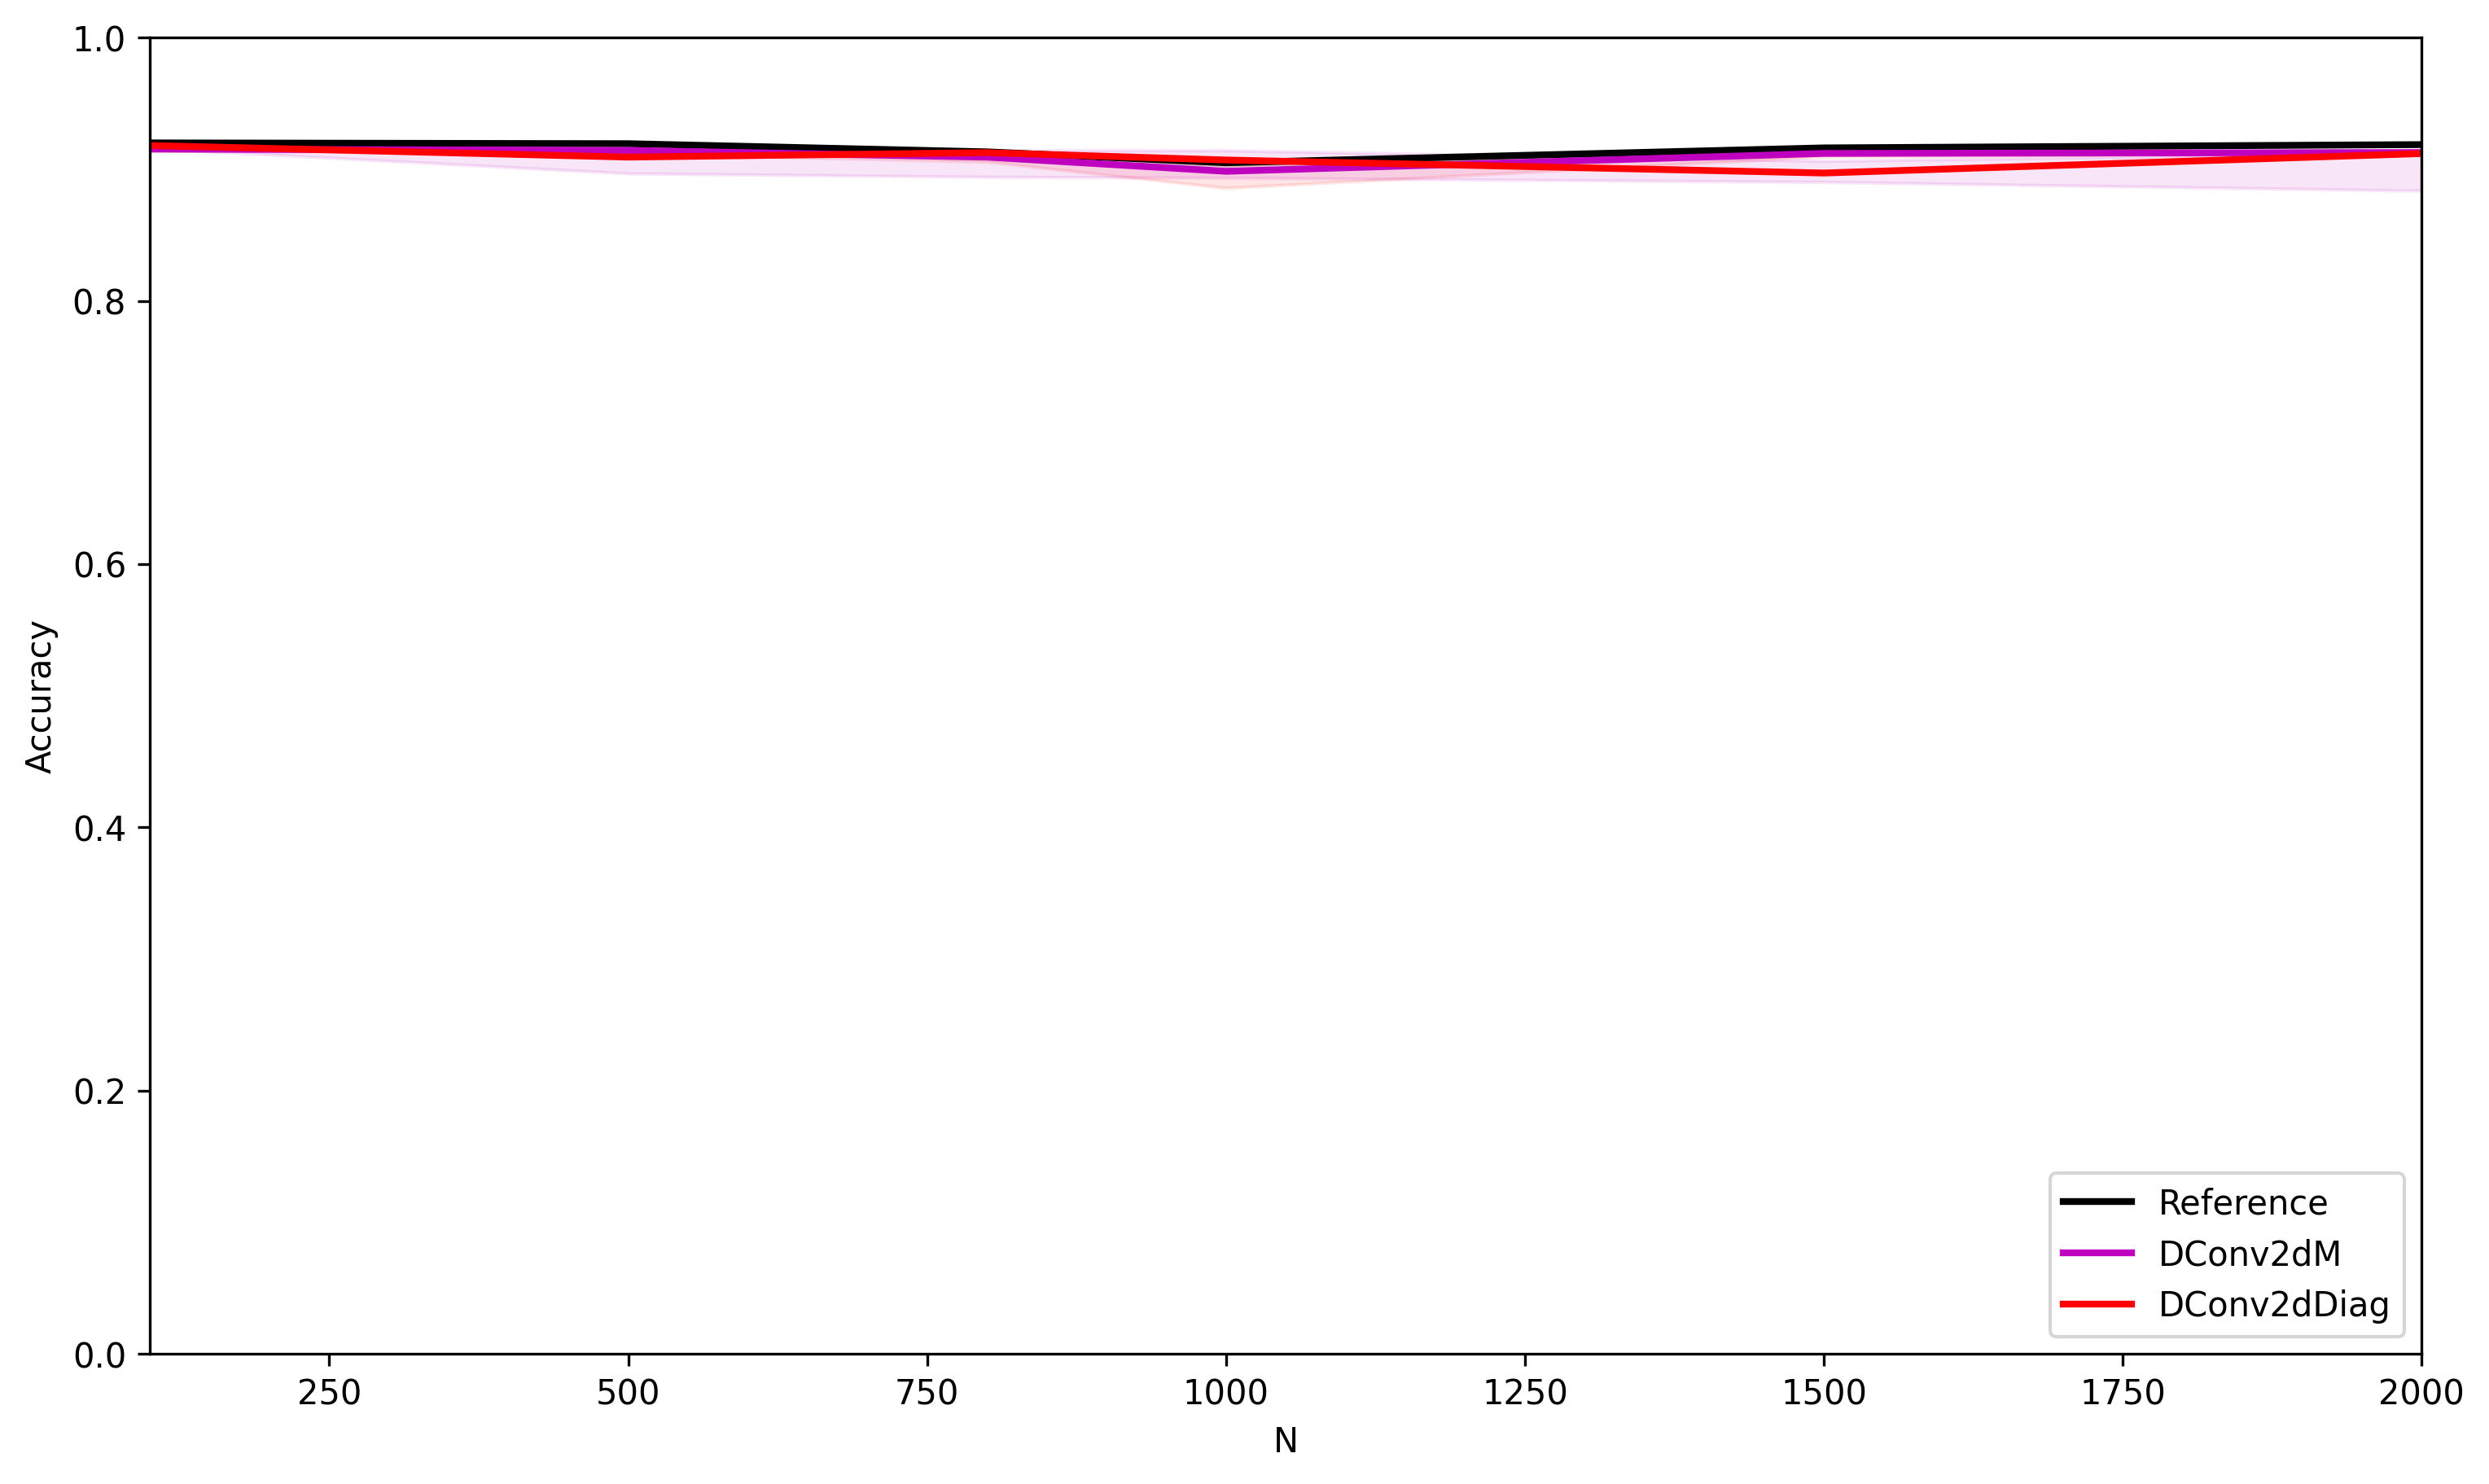

In [66]:
fig, ax = plt.subplots(num=1,figsize=(12,7),dpi=300)

ax.axis([100, 2000, 0, 1])

ax.plot(data.index, data.med, lw=2, label='Reference', color="k")
ax.plot(data1.index, data1.med, lw=2, label='DConv2dM', color="m")
ax.plot(data2.index, data2.med, lw=2, label='DConv2dDiag', color="r")

ax.fill_between(data.index,data.q1,data.q1, color='k', alpha=0.1)
ax.fill_between(data1.index,data1.q1,data1.q2, color='r', alpha=0.1)
ax.fill_between(data2.index,data2.q1,data2.q2, color='m', alpha=0.1)

ax.legend(loc='lower right')
ax.set_xlabel('N')
ax.set_ylabel('Accuracy')

In [67]:
data3=get_accuracy(name_file="Reference",i=2)
data3["q1"]=data3[["r1",'r2',"r3","r4","r5"]].quantile(0.25,axis=1)
data3["q2"]=data3[["r1",'r2',"r3","r4","r5"]].quantile(0.75,axis=1)
data3["med"]=data3[["r1",'r2',"r3","r4","r5"]].median(axis=1)

In [68]:
data3

,r1,r2,r3,r4,r5,vmax,vmin,vmean,sigma,q1,q2,med
N,,,,,,,,,,,,
20,0.9552,0.9454,0.9538,0.9303,0.9416,0.9552,0.9303,0.944543,0.010111,0.9416,0.9538,0.9454
80,0.9471,0.9433,0.9474,0.9487,0.9562,0.9562,0.9433,0.948886,0.004731,0.9471,0.9487,0.9474
100,0.9474,0.9484,0.9496,0.9485,0.9565,0.9565,0.9474,0.950614,0.003672,0.9484,0.9496,0.9485
500,0.9361,0.9311,0.9355,0.9308,0.9427,0.9427,0.9308,0.935671,0.004830,0.9311,0.9361,0.9355
800,0.9288,0.9363,0.9465,0.9219,0.9219,0.9465,0.9219,0.931971,0.010473,0.9219,0.9363,0.9288
1000,0.9356,0.9343,0.9282,0.9353,0.9317,0.9356,0.9282,0.932700,0.003101,0.9317,0.9353,0.9343
1500,0.9161,0.9355,0.0980,0.9340,0.9179,0.9355,0.0980,0.690714,0.370344,0.9161,0.9340,0.9179
2000,0.8697,0.8622,0.8840,0.8439,0.8603,0.8840,0.8439,0.864000,0.014607,0.8603,0.8697,0.8622


In [69]:
data4=get_accuracy(name_file="DConv2dM",i=2)
data4["q1"]=data4[["r1",'r2',"r3","r4","r5"]].quantile(0.25,axis=1)
data4["q2"]=data4[["r1",'r2',"r3","r4","r5"]].quantile(0.75,axis=1)
data4["med"]=data4[["r1",'r2',"r3","r4","r5"]].median(axis=1)

In [70]:
data4

,r1,r2,r3,r4,r5,vmax,vmin,vmean,sigma,q1,q2,med
N,,,,,,,,,,,,
20,0.9526,0.9512,0.9534,0.9591,0.9583,0.9591,0.9512,0.954986,0.003551,0.9526,0.9583,0.9534
80,0.9577,0.9514,0.9596,0.9606,0.9537,0.9606,0.9514,0.956429,0.003926,0.9537,0.9596,0.9577
100,0.9566,0.9583,0.9586,0.9584,0.9562,0.9586,0.9562,0.957557,0.001128,0.9566,0.9584,0.9583
500,0.9537,0.9538,0.9494,0.9482,0.9585,0.9585,0.9482,0.952900,0.004092,0.9494,0.9538,0.9537
800,0.9581,0.9524,0.9472,0.9479,0.9432,0.9581,0.9432,0.950014,0.005691,0.9472,0.9524,0.9479
1000,0.9463,0.9432,0.9496,0.9544,0.9389,0.9544,0.9389,0.946529,0.005931,0.9432,0.9496,0.9463
1500,0.9467,0.9496,0.9468,0.9554,0.9438,0.9554,0.9438,0.948786,0.004388,0.9467,0.9496,0.9468
2000,0.9531,0.9478,0.9467,0.9518,0.9528,0.9531,0.9467,0.950286,0.002977,0.9478,0.9528,0.9518


In [71]:
data5=get_accuracy(name_file="DConv2dDiag",i=2)
data5["q1"]=data5[["r1",'r2',"r3","r4","r5"]].quantile(0.25,axis=1)
data5["q2"]=data5[["r1",'r2',"r3","r4","r5"]].quantile(0.75,axis=1)
data5["med"]=data5[["r1",'r2',"r3","r4","r5"]].median(axis=1)

In [72]:
data5

,r1,r2,r3,r4,r5,vmax,vmin,vmean,sigma,q1,q2,med
N,,,,,,,,,,,,
20,0.9401,0.9354,0.9368,0.9374,0.9212,0.9401,0.9212,0.933171,0.007454,0.9354,0.9374,0.9368
80,0.9356,0.9335,0.9348,0.9394,0.9405,0.9405,0.9335,0.936829,0.003032,0.9348,0.9394,0.9356
100,0.9335,0.9309,0.9414,0.9331,0.9430,0.9430,0.9309,0.936543,0.005434,0.9331,0.9414,0.9335
500,0.9294,0.9421,0.9329,0.9404,0.9318,0.9421,0.9294,0.935443,0.005592,0.9318,0.9404,0.9329
800,0.9333,0.9343,0.9353,0.9318,0.9253,0.9353,0.9253,0.931514,0.003962,0.9318,0.9343,0.9333
1000,0.9460,0.9459,0.9322,0.9390,0.9311,0.9460,0.9311,0.938757,0.007161,0.9322,0.9459,0.9390
1500,0.9219,0.9325,0.9212,0.9312,0.9378,0.9378,0.9212,0.929086,0.007172,0.9219,0.9325,0.9312
2000,0.9323,0.9241,0.9105,0.9241,0.9481,0.9481,0.9105,0.928243,0.013775,0.9241,0.9323,0.9241


## Conv Matrix filters, 2

Text(0, 0.5, 'Accuracy')

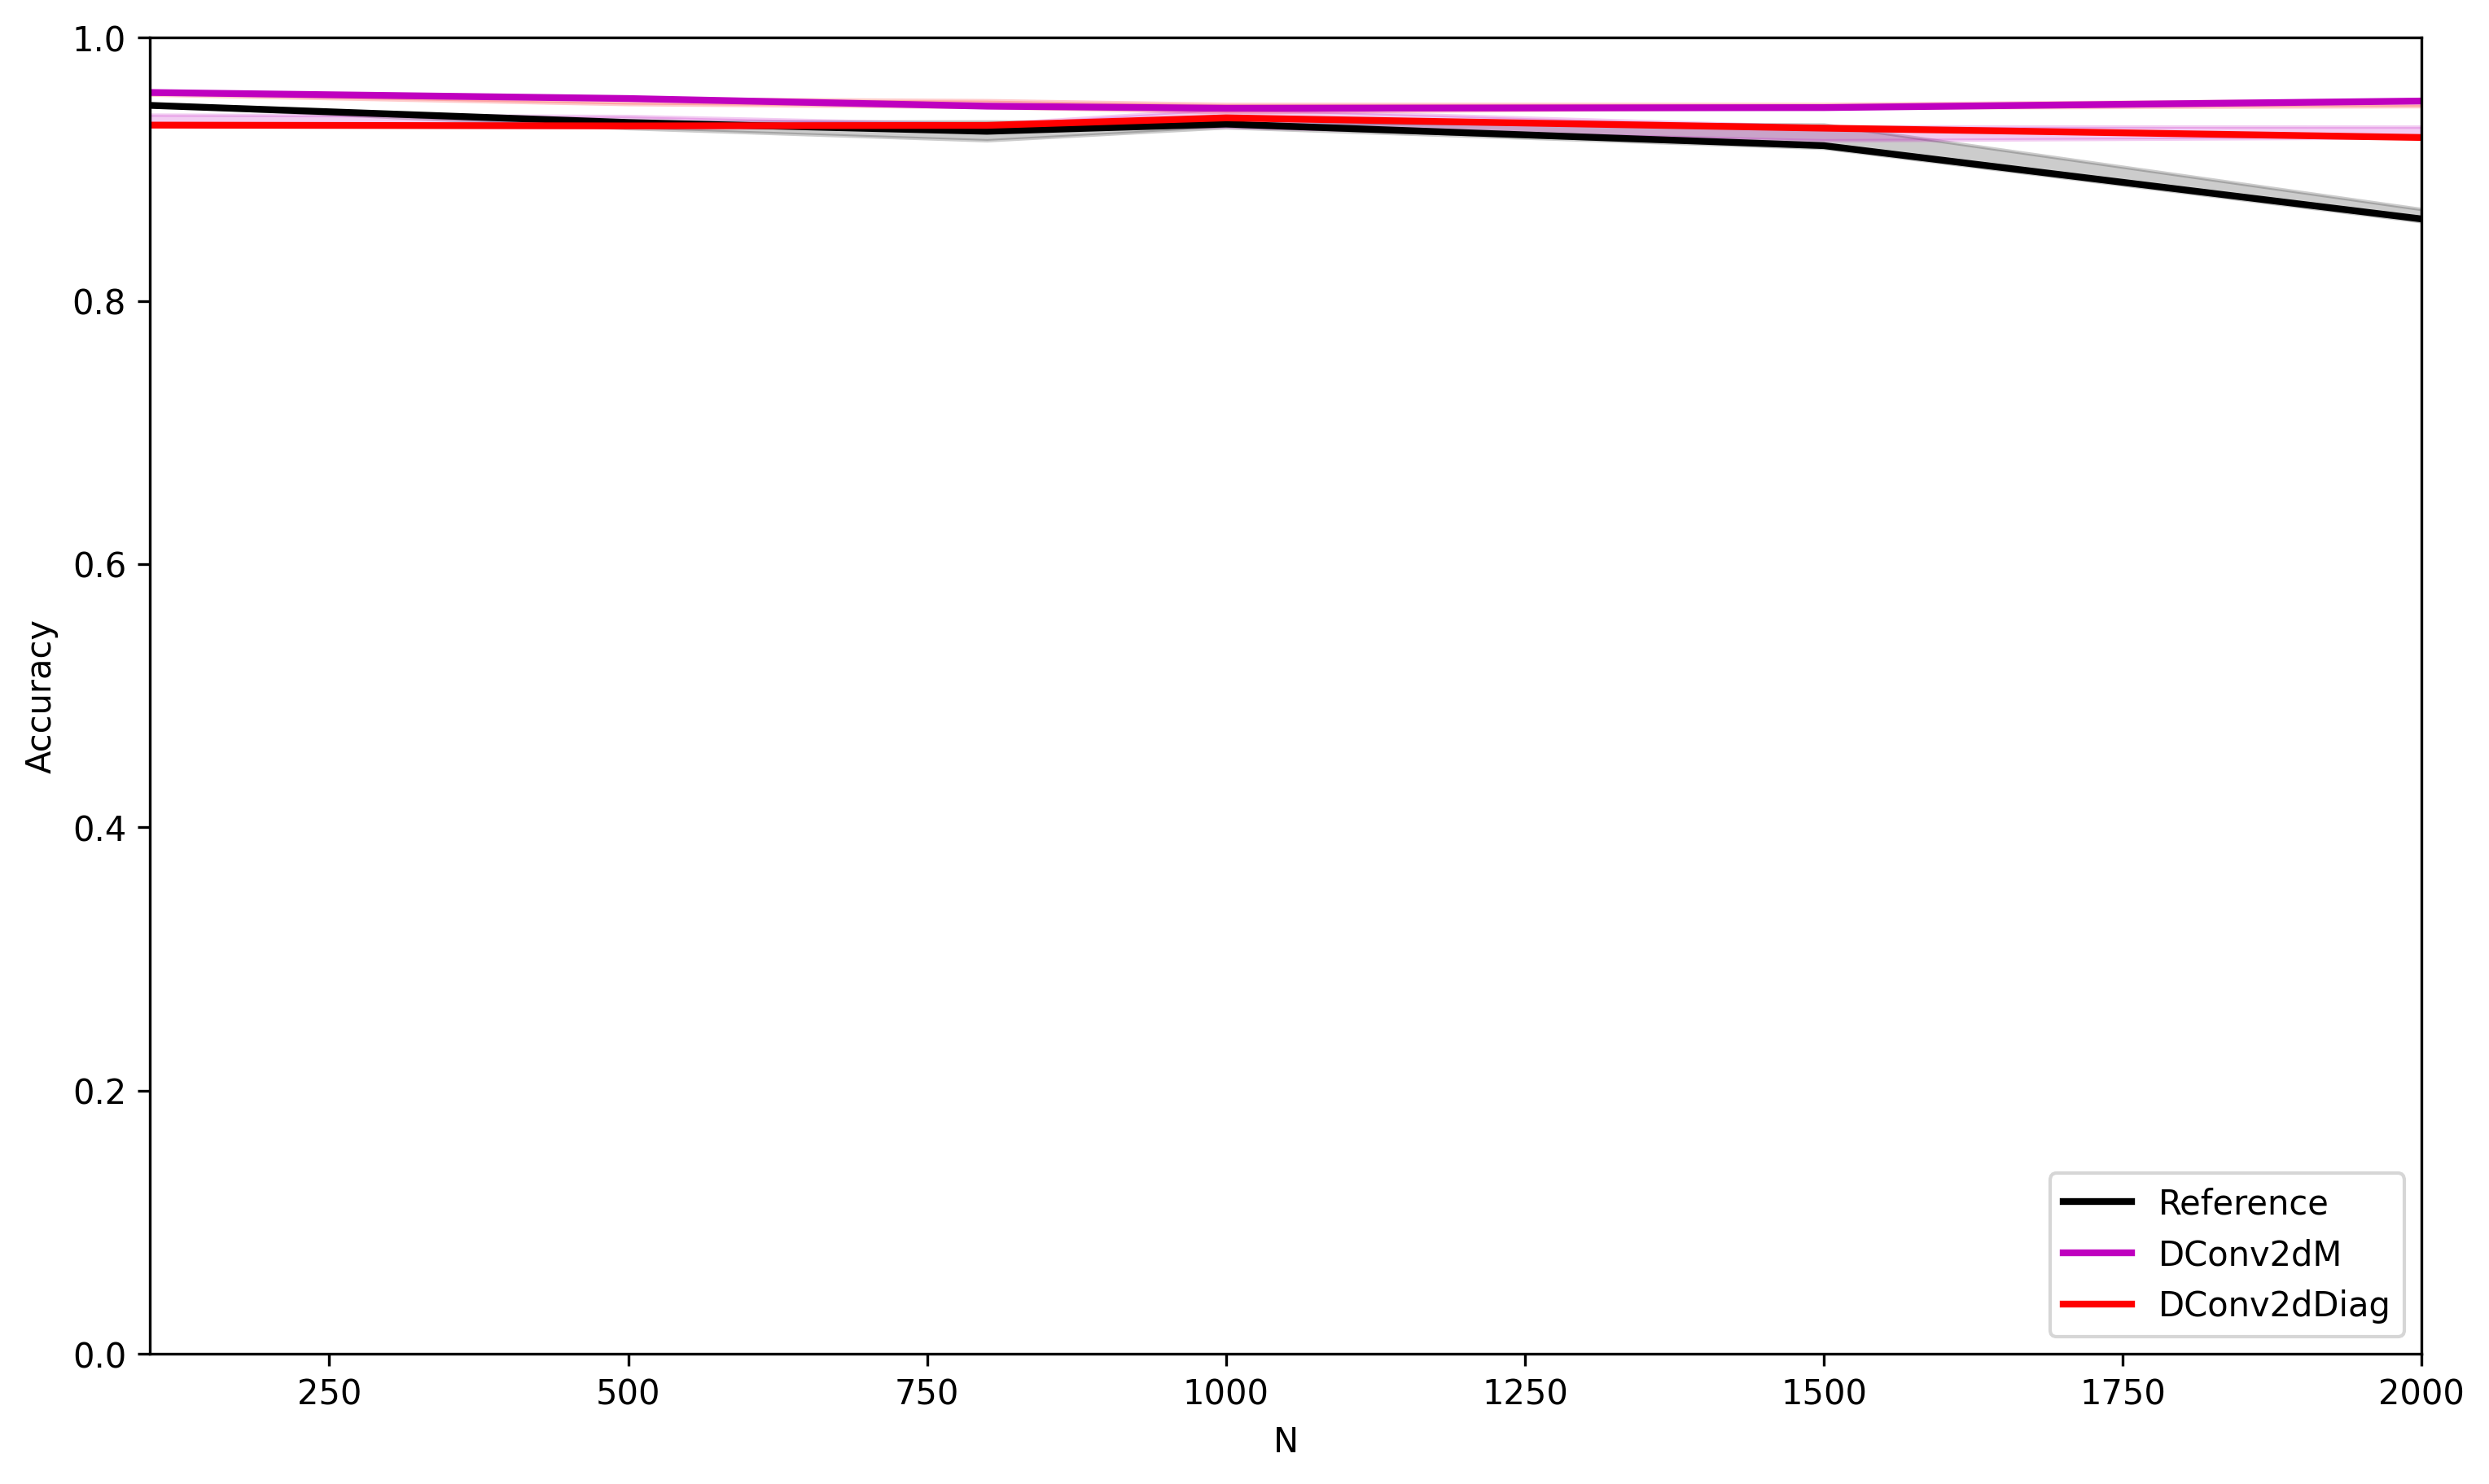

In [76]:
fig, ax = plt.subplots(num=1,figsize=(12,7),dpi=300)

ax.axis([100, 2000, 0, 1])

ax.plot(data3.index, data3.med, lw=2, label='Reference', color="k")
ax.plot(data4.index, data4.med, lw=2, label='DConv2dM', color="m")
ax.plot(data5.index, data5.med, lw=2, label='DConv2dDiag', color="r")

ax.fill_between(data3.index,data3.q1,data3.q2, color='k', alpha=0.2)
ax.fill_between(data4.index,data4.q1,data4.q2, color='r', alpha=0.2)
ax.fill_between(data5.index,data5.q1,data5.q2, color='m', alpha=0.2)

ax.legend(loc='lower right')
ax.set_xlabel('N')
ax.set_ylabel('Accuracy')

In [78]:
data6=get_accuracy(name_file="ReferenceStrides",i=1)
data6["q1"]=data6[["r1",'r2',"r3","r4","r5"]].quantile(0.25,axis=1)
data6["q2"]=data6[["r1",'r2',"r3","r4","r5"]].quantile(0.75,axis=1)
data6["med"]=data6[["r1",'r2',"r3","r4","r5"]].median(axis=1)

In [79]:
data6

,r1,r2,r3,r4,r5,vmax,vmin,vmean,sigma,q1,q2,med
S,,,,,,,,,,,,
1,0.9078,0.0980,0.8979,0.8984,0.9214,0.9214,0.0980,0.677557,0.361642,0.8979,0.9078,0.8984
2,0.8377,0.8382,0.8415,0.8317,0.8494,0.8494,0.8317,0.839943,0.006473,0.8377,0.8415,0.8382
3,0.6744,0.6981,0.7643,0.7757,0.7711,0.7757,0.6744,0.733386,0.047004,0.6981,0.7711,0.7643
4,0.6241,0.5149,0.5431,0.6173,0.4990,0.6241,0.4990,0.560214,0.057949,0.5149,0.6173,0.5431
5,0.3487,0.4055,0.3641,0.2311,0.3465,0.4055,0.2311,0.333214,0.064894,0.3465,0.3641,0.3487


In [82]:
data7=extract_accuracy_and_save(name_file="DConv2dOmegaStrides",i=1)
data7["q1"]=data7[["r1",'r2',"r3","r4","r5"]].quantile(0.25,axis=1)
data7["q2"]=data7[["r1",'r2',"r3","r4","r5"]].quantile(0.75,axis=1)
data7["med"]=data7[["r1",'r2',"r3","r4","r5"]].median(axis=1)

In [83]:
data7

,r1,r2,r3,r4,r5,vmax,vmin,vmean,sigma,q1,q2,med
S,,,,,,,,,,,,
1,0.9089,0.9245,0.9144,0.9019,0.9091,0.9245,0.9019,0.912171,0.008393,0.9089,0.9144,0.9091
2,0.8834,0.8815,0.8419,0.8741,0.8704,0.8834,0.8419,0.868086,0.016719,0.8704,0.8815,0.8741
3,0.7773,0.7719,0.7785,0.7754,0.7878,0.7878,0.7719,0.778657,0.005928,0.7754,0.7785,0.7773
4,0.6329,0.6457,0.6383,0.6478,0.6345,0.6478,0.6329,0.639986,0.006647,0.6345,0.6457,0.6383
5,0.3808,0.3812,0.3763,0.3808,0.3978,0.3978,0.3763,0.384429,0.008309,0.3808,0.3812,0.3808


In [84]:
data8=extract_accuracy_and_save(name_file="DConv2dOmegaDiagStrides",i=1)
data8["q1"]=data8[["r1",'r2',"r3","r4","r5"]].quantile(0.25,axis=1)
data8["q2"]=data8[["r1",'r2',"r3","r4","r5"]].quantile(0.75,axis=1)
data8["med"]=data8[["r1",'r2',"r3","r4","r5"]].median(axis=1)

In [85]:
data8

,r1,r2,r3,r4,r5,vmax,vmin,vmean,sigma,q1,q2,med
S,,,,,,,,,,,,
1,0.9091,0.9067,0.9122,0.9067,0.8994,0.9122,0.8994,0.906529,0.004723,0.9067,0.9091,0.9067
2,0.8696,0.8798,0.8563,0.8691,0.8467,0.8798,0.8467,0.864000,0.012895,0.8563,0.8696,0.8691
3,0.7500,0.7488,0.7693,0.7164,0.7522,0.7693,0.7164,0.746057,0.019186,0.7488,0.7522,0.7500
4,0.5824,0.5460,0.5366,0.5659,0.5752,0.5824,0.5366,0.560729,0.019389,0.5460,0.5752,0.5659
5,0.3629,0.3578,0.3566,0.3375,0.3239,0.3629,0.3239,0.346500,0.016452,0.3375,0.3578,0.3566


## Conv Matrix Strides

Text(0, 0.5, 'Accuracy')

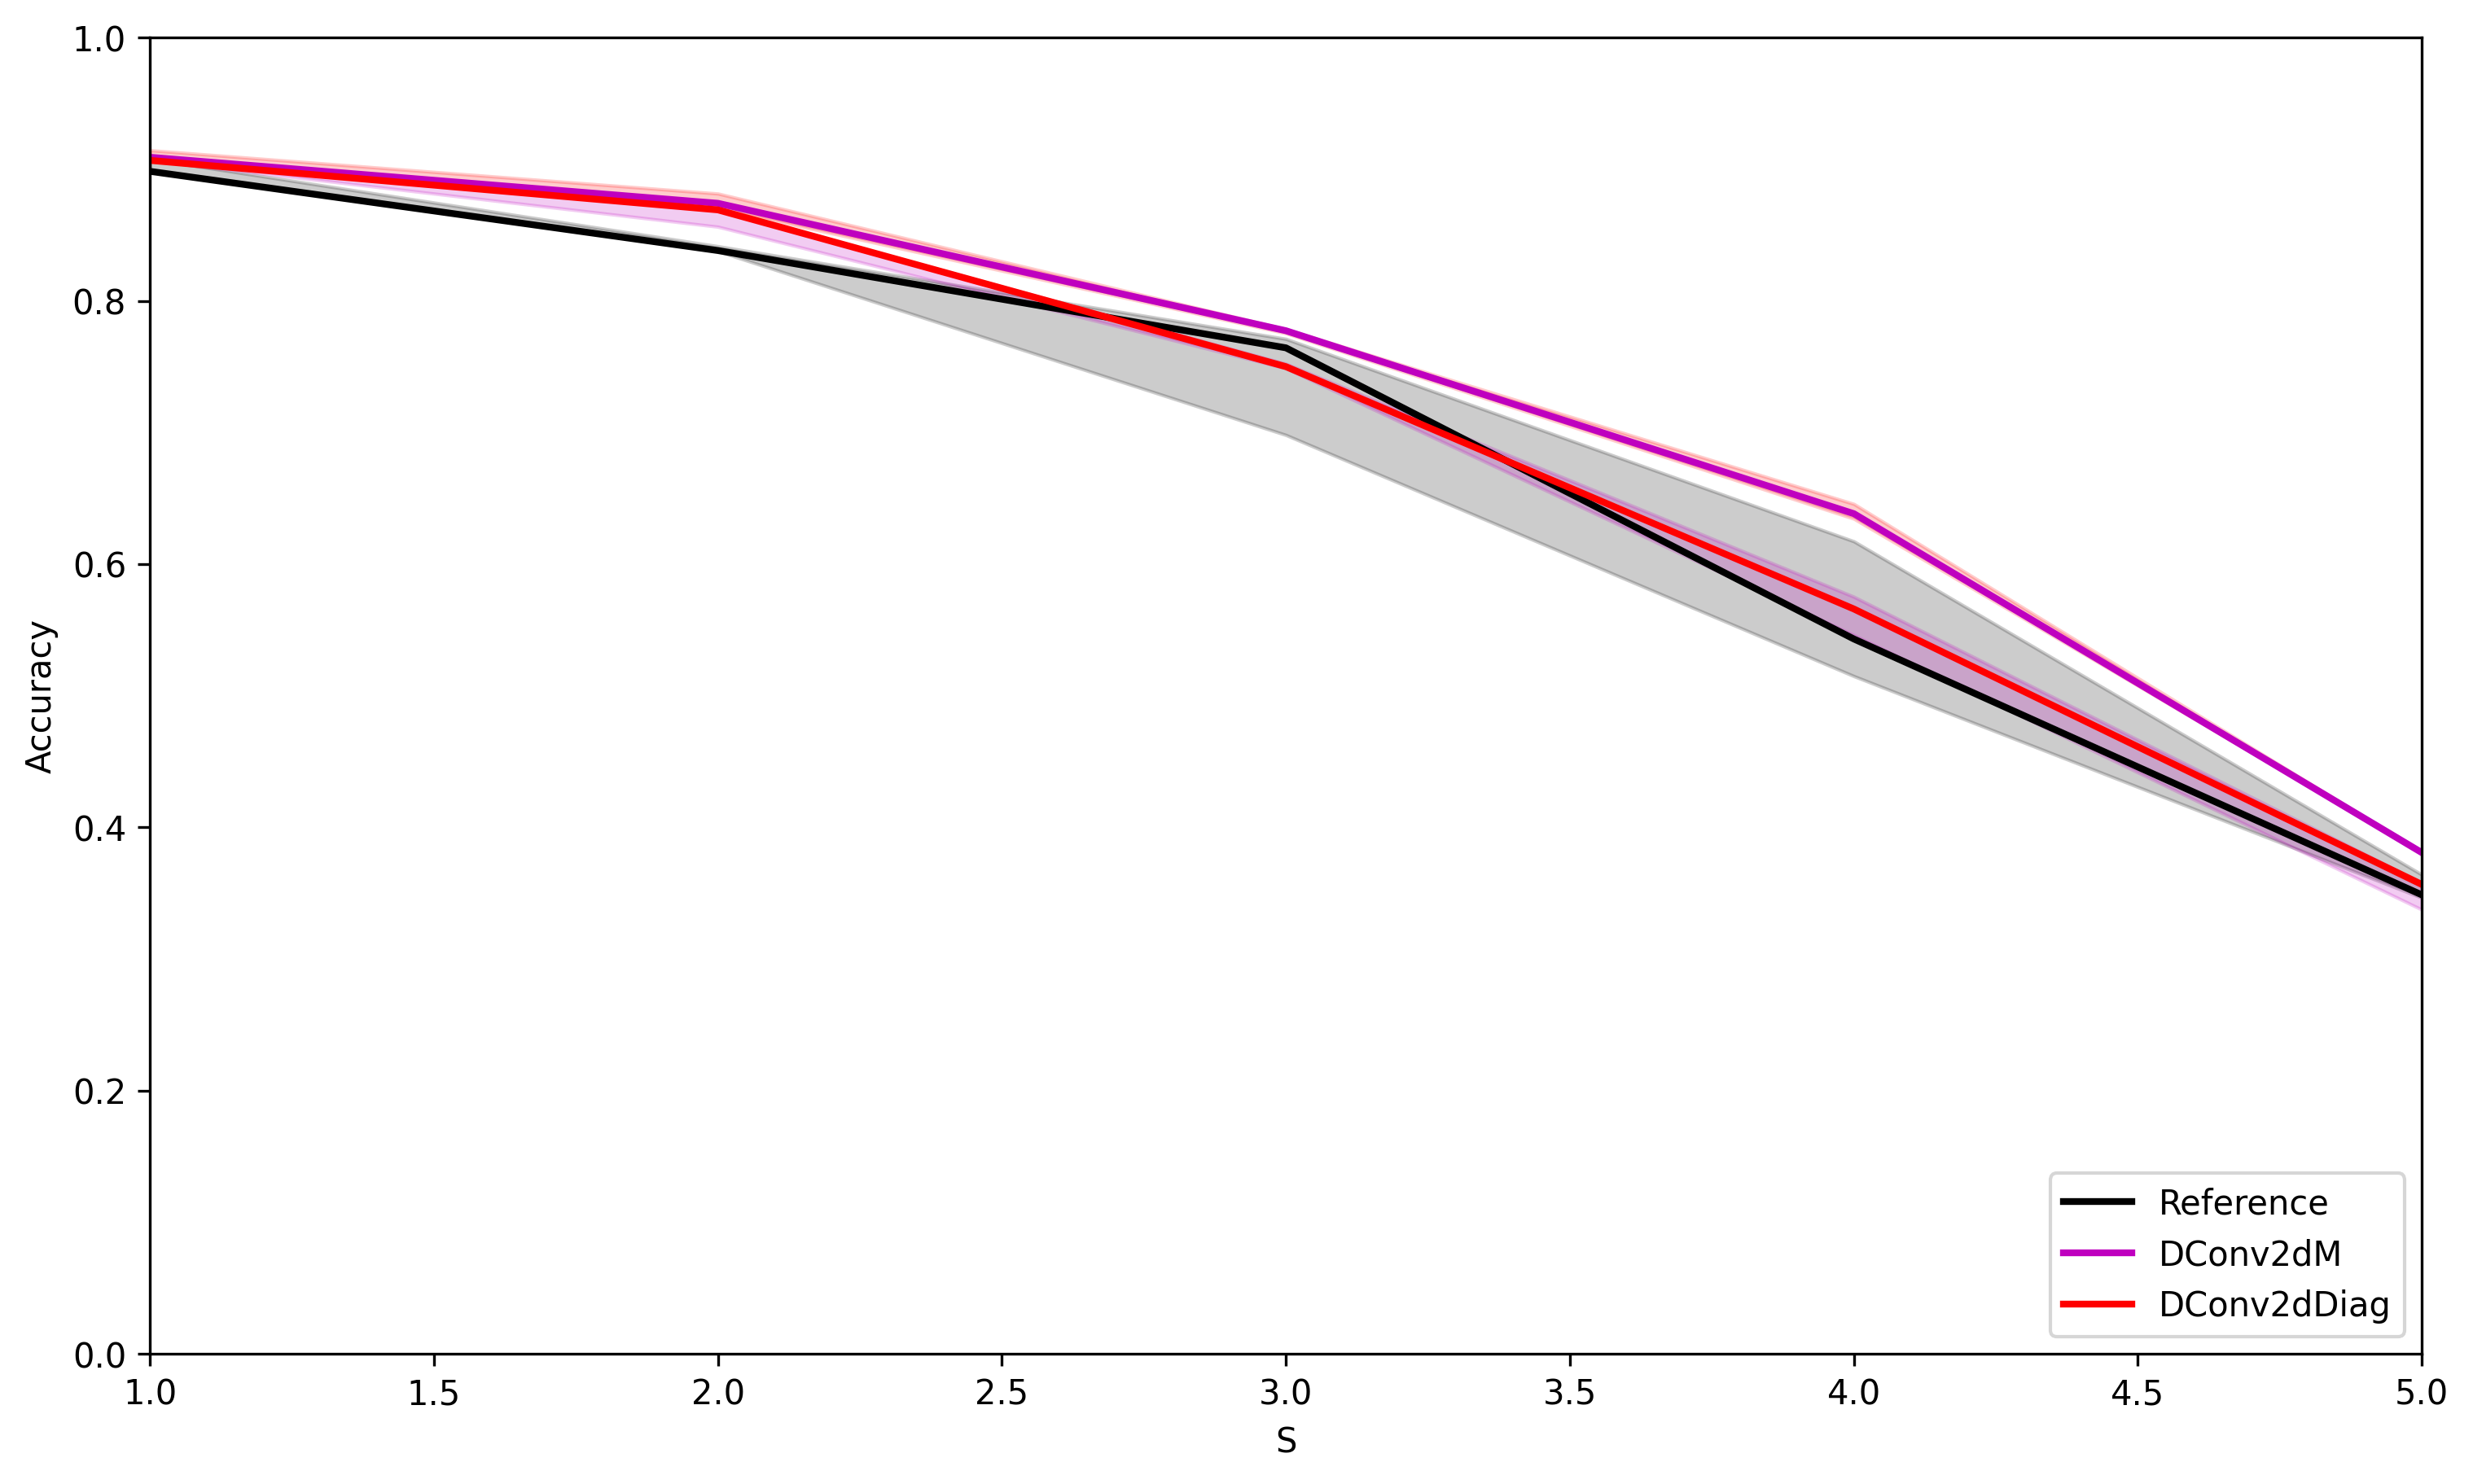

In [88]:
fig, ax = plt.subplots(num=1,figsize=(12,7),dpi=300)

ax.axis([1, 5, 0, 1])

ax.plot(data6.index, data6.med, lw=2, label='Reference', color="k")
ax.plot(data7.index, data7.med, lw=2, label='DConv2dM', color="m")
ax.plot(data8.index, data8.med, lw=2, label='DConv2dDiag', color="r")

ax.fill_between(data6.index,data6.q1,data6.q2, color='k', alpha=0.2)
ax.fill_between(data7.index,data7.q1,data7.q2, color='r', alpha=0.2)
ax.fill_between(data8.index,data8.q1,data8.q2, color='m', alpha=0.2)

ax.legend(loc='lower right')
ax.set_xlabel('S')
ax.set_ylabel('Accuracy')

In [90]:
data9=extract_accuracy_and_save(name_file="DConv2dM",i=2)
data9["q1"]=data9[["r1",'r2',"r3","r4","r5"]].quantile(0.25,axis=1)
data9["q2"]=data9[["r1",'r2',"r3","r4","r5"]].quantile(0.75,axis=1)
data9["med"]=data9[["r1",'r2',"r3","r4","r5"]].median(axis=1)
data9

,r1,r2,r3,r4,r5,vmax,vmin,vmean,sigma,q1,q2,med
N,,,,,,,,,,,,
20,0.9526,0.9512,0.9534,0.9591,0.9583,0.9591,0.9512,0.954986,0.003551,0.9526,0.9583,0.9534
80,0.9577,0.9514,0.9596,0.9606,0.9537,0.9606,0.9514,0.956429,0.003926,0.9537,0.9596,0.9577
100,0.9566,0.9583,0.9586,0.9584,0.9562,0.9586,0.9562,0.957557,0.001128,0.9566,0.9584,0.9583
500,0.9537,0.9538,0.9494,0.9482,0.9585,0.9585,0.9482,0.952900,0.004092,0.9494,0.9538,0.9537
800,0.9581,0.9524,0.9472,0.9479,0.9432,0.9581,0.9432,0.950014,0.005691,0.9472,0.9524,0.9479
1000,0.9463,0.9432,0.9496,0.9544,0.9389,0.9544,0.9389,0.946529,0.005931,0.9432,0.9496,0.9463
1500,0.9467,0.9496,0.9468,0.9554,0.9438,0.9554,0.9438,0.948786,0.004388,0.9467,0.9496,0.9468
2000,0.9531,0.9478,0.9467,0.9518,0.9528,0.9531,0.9467,0.950286,0.002977,0.9478,0.9528,0.9518


In [91]:
data10=extract_accuracy_and_save(name_file="SpecConv2dOmegaDiag",i=2)
data10["q1"]=data10[["r1",'r2',"r3","r4","r5"]].quantile(0.25,axis=1)
data10["q2"]=data10[["r1",'r2',"r3","r4","r5"]].quantile(0.75,axis=1)
data10["med"]=data10[["r1",'r2',"r3","r4","r5"]].median(axis=1)
data10

,r1,r2,r3,r4,r5,vmax,vmin,vmean,sigma,q1,q2,med
N,,,,,,,,,,,,
20,0.3915,0.3331,0.4293,0.4235,0.4225,0.4293,0.3331,0.394614,0.040202,0.3915,0.4235,0.4225
80,0.5713,0.6704,0.6047,0.6739,0.6464,0.6739,0.5713,0.630271,0.044324,0.6047,0.6704,0.6464
100,0.6812,0.7227,0.6775,0.6713,0.7090,0.7227,0.6713,0.693671,0.022284,0.6775,0.7090,0.6812
500,0.8929,0.8983,0.8943,0.8921,0.8917,0.8983,0.8917,0.894186,0.002674,0.8921,0.8943,0.8929
800,0.9130,0.9103,0.9075,0.9131,0.9082,0.9131,0.9075,0.910386,0.002613,0.9082,0.9130,0.9103
1000,0.9136,0.9160,0.9176,0.9160,0.9181,0.9181,0.9136,0.916143,0.001760,0.9160,0.9176,0.9160
1500,0.9211,0.9230,0.9200,0.9181,0.9132,0.9230,0.9132,0.918800,0.003736,0.9181,0.9211,0.9200
2000,0.9370,0.9290,0.9312,0.9204,0.9309,0.9370,0.9204,0.929414,0.005999,0.9290,0.9312,0.9309


In [92]:
data11=extract_accuracy_and_save(name_file="DscConv2dDiag",i=2)
data11["q1"]=data11[["r1",'r2',"r3","r4","r5"]].quantile(0.25,axis=1)
data11["q2"]=data11[["r1",'r2',"r3","r4","r5"]].quantile(0.75,axis=1)
data11["med"]=data11[["r1",'r2',"r3","r4","r5"]].median(axis=1)
data11

,r1,r2,r3,r4,r5,vmax,vmin,vmean,sigma,q1,q2,med
N,,,,,,,,,,,,
20,0.3758,0.3115,0.2860,0.3469,0.2601,0.3758,0.2601,0.316600,0.046303,0.2860,0.3469,0.3115
80,0.4994,0.5351,0.5196,0.5570,0.4908,0.5570,0.4908,0.521386,0.026802,0.4994,0.5351,0.5196
100,0.6719,0.5477,0.5322,0.5654,0.5401,0.6719,0.5322,0.580200,0.057477,0.5401,0.5654,0.5477
500,0.8656,0.8656,0.8611,0.7552,0.8662,0.8662,0.7552,0.833586,0.048979,0.8611,0.8656,0.8656
800,0.8954,0.9000,0.9007,0.8952,0.8937,0.9007,0.8937,0.897057,0.003138,0.8952,0.9000,0.8954
1000,0.9014,0.9045,0.8975,0.9081,0.9045,0.9081,0.8975,0.903086,0.003972,0.9014,0.9045,0.9045
1500,0.9155,0.9105,0.8967,0.9133,0.9088,0.9155,0.8967,0.908143,0.007320,0.9088,0.9133,0.9105
2000,0.9153,0.9148,0.9174,0.9126,0.9256,0.9256,0.9126,0.917700,0.005028,0.9148,0.9174,0.9153


## Conv2D Réduction des parms

Text(0, 0.5, 'Accuracy')

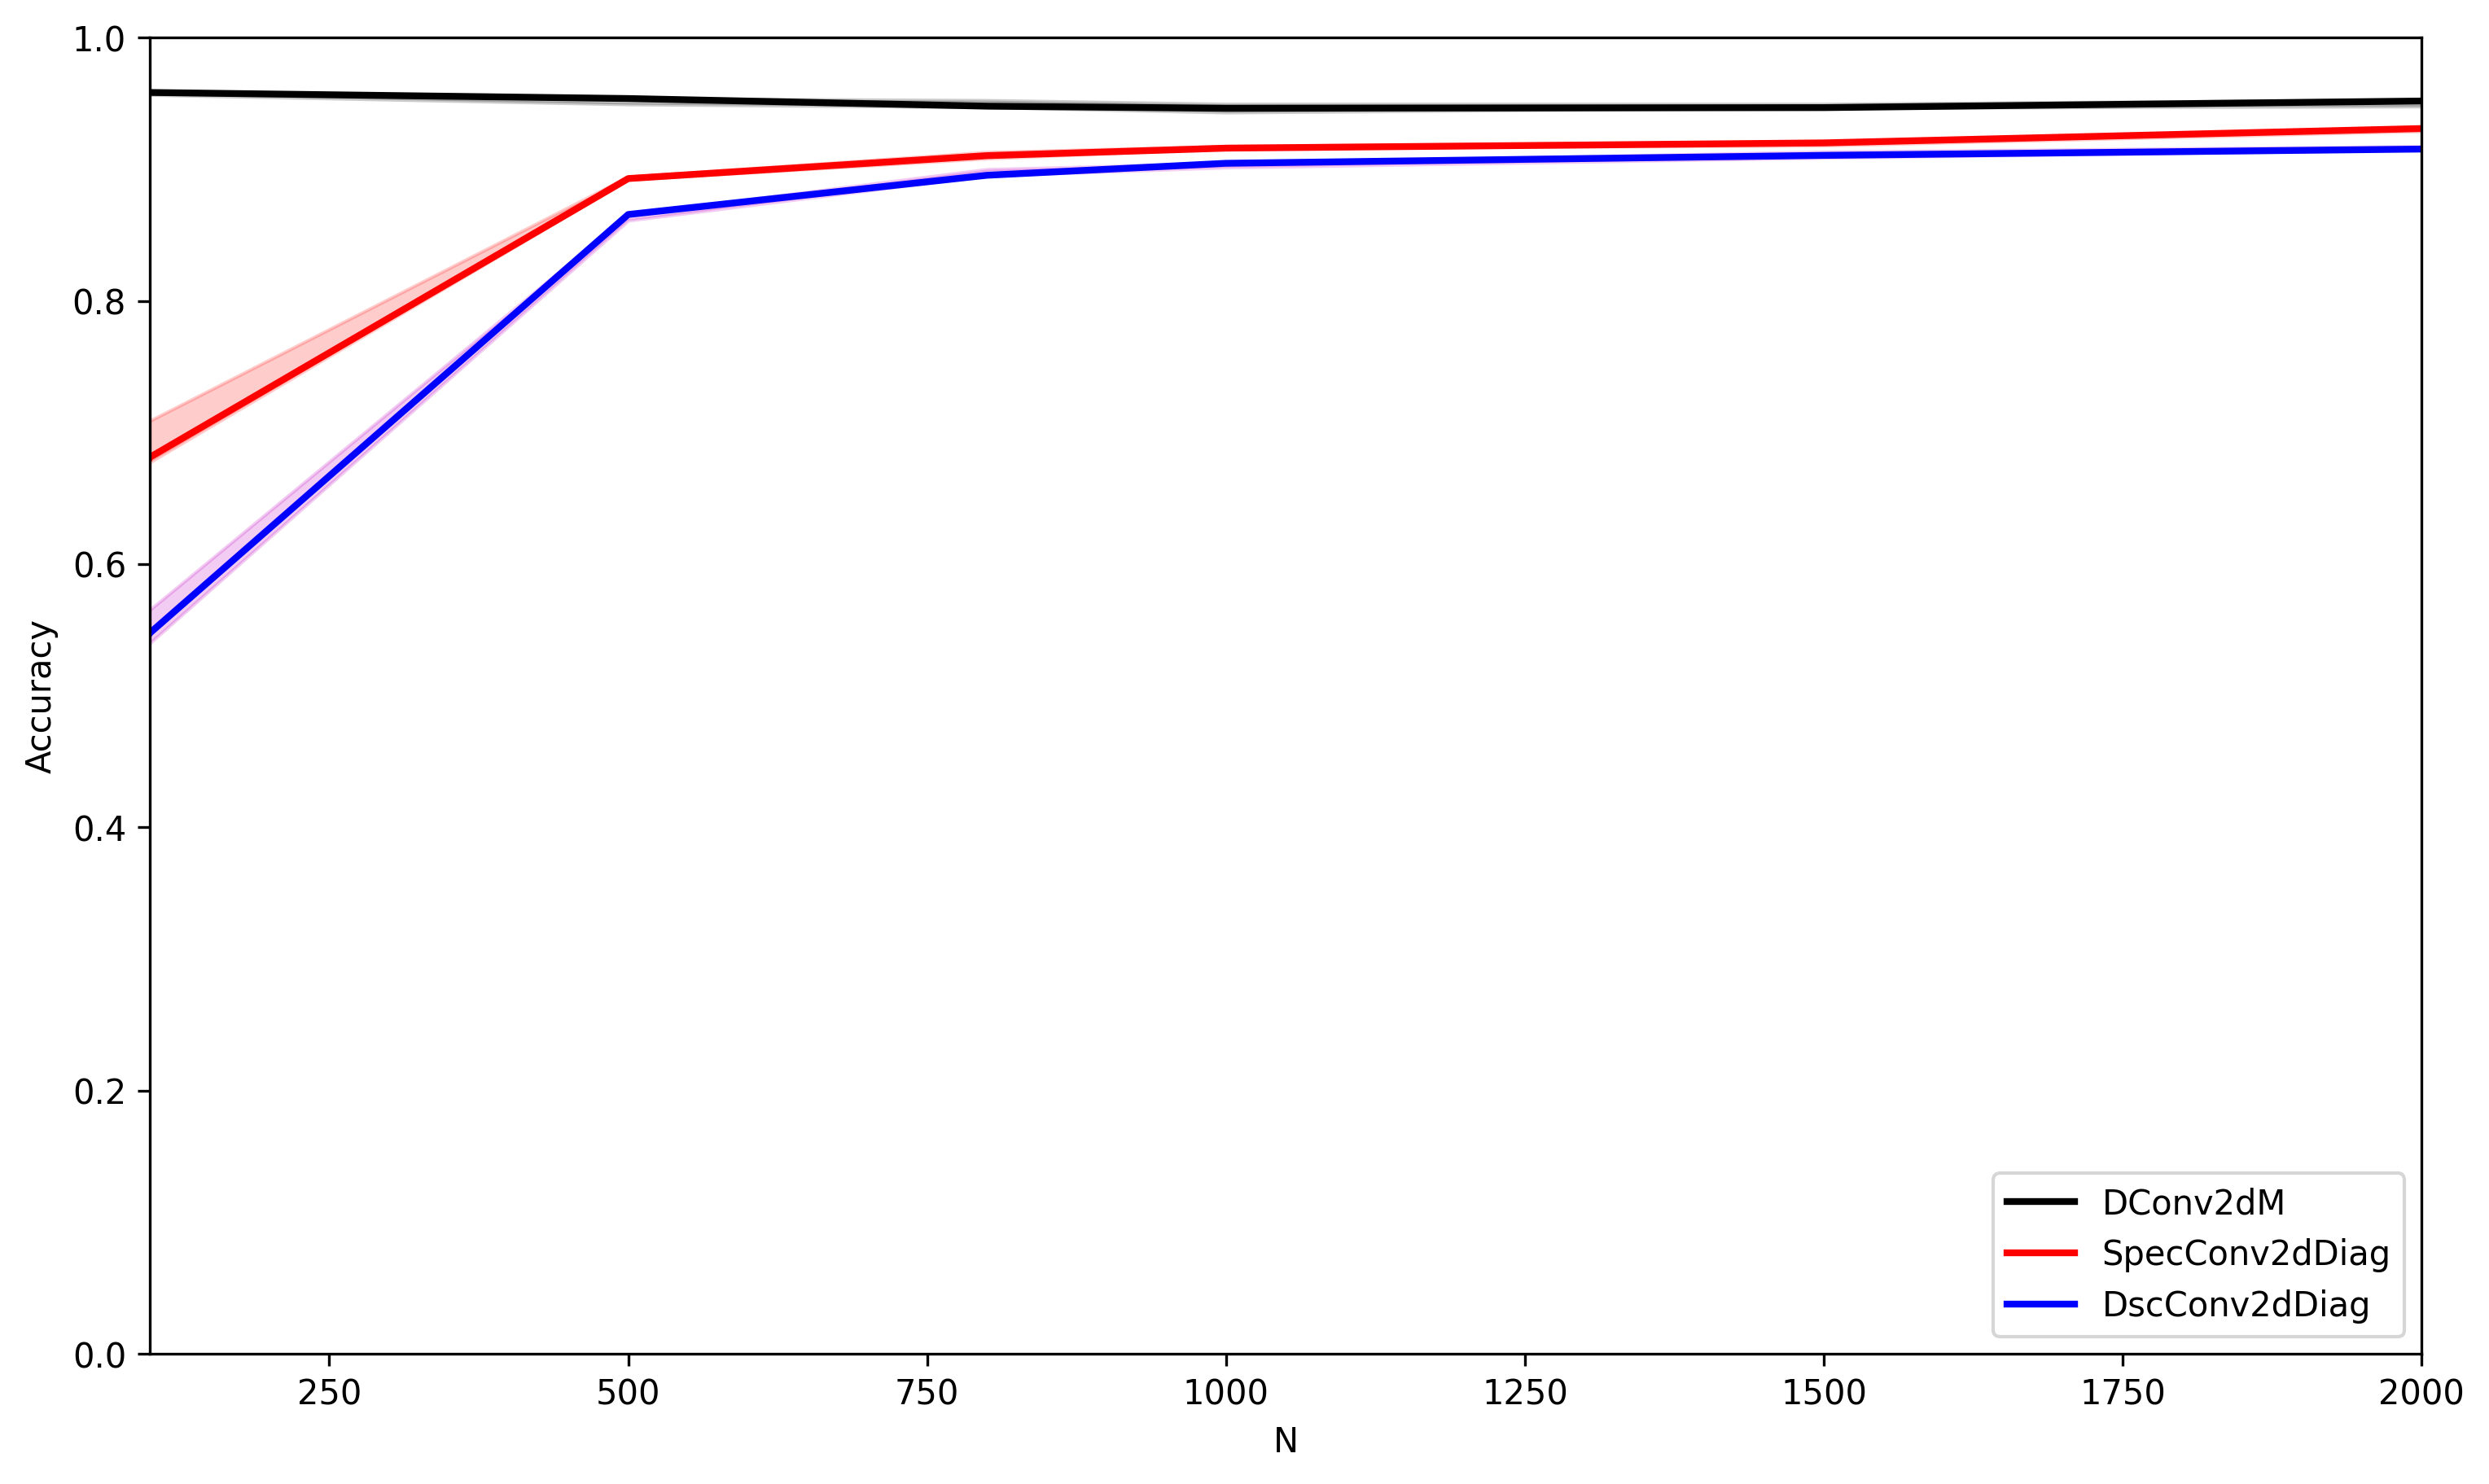

In [97]:
fig, ax = plt.subplots(num=1,figsize=(12,7),dpi=300)

ax.axis([100, 2000, 0, 1])

ax.plot(data9.index, data9.med, lw=2, label='DConv2dM', color="k")
ax.plot(data10.index, data10.med, lw=2, label='SpecConv2dDiag', color="r")
ax.plot(data11.index, data11.med, lw=2, label='DscConv2dDiag', color="b")

ax.fill_between(data9.index,data9.q1,data9.q2, color='k', alpha=0.2)
ax.fill_between(data10.index,data10.q1,data10.q2, color='r', alpha=0.2)
ax.fill_between(data11.index,data11.q1,data11.q2, color='m', alpha=0.2)

ax.legend(loc='lower right')
ax.set_xlabel('N')
ax.set_ylabel('Accuracy')

In [102]:
data12=get_accuracy(name_file="SpecConv2dClassique",i=2)
data12["q1"]=data12[["r1",'r2',"r3","r4","r5"]].quantile(0.25,axis=1)
data12["q2"]=data12[["r1",'r2',"r3","r4","r5"]].quantile(0.75,axis=1)
data12["med"]=data12[["r1",'r2',"r3","r4","r5"]].median(axis=1)
data12

,r1,r2,r3,r4,r5,vmax,vmin,vmean,sigma,q1,q2,med
N,,,,,,,,,,,,
20,0.4535,0.4519,0.4268,0.4843,0.4604,0.4843,0.4268,0.455429,0.020579,0.4519,0.4604,0.4535
80,0.6876,0.7045,0.6775,0.7151,0.6421,0.7151,0.6421,0.683429,0.028236,0.6775,0.7045,0.6876
100,0.7396,0.7235,0.7655,0.7463,0.7262,0.7655,0.7235,0.741443,0.016975,0.7262,0.7463,0.7396
500,0.9252,0.9235,0.9076,0.9106,0.9026,0.9252,0.9026,0.913900,0.009976,0.9076,0.9235,0.9106
800,0.9104,0.9334,0.9388,0.9147,0.9322,0.9388,0.9104,0.925529,0.012530,0.9147,0.9334,0.9322
1000,0.9467,0.9119,0.9481,0.9307,0.9438,0.9481,0.9119,0.934457,0.015251,0.9307,0.9467,0.9438
1500,0.9496,0.9434,0.9526,0.9509,0.9539,0.9539,0.9434,0.949671,0.004076,0.9496,0.9526,0.9509
2000,0.9164,0.9183,0.9508,0.9561,0.9518,0.9561,0.9164,0.937986,0.019585,0.9183,0.9518,0.9508


In [103]:
data13=get_accuracy(name_file="DscConv2dClassique",i=2)
data13["q1"]=data13[["r1",'r2',"r3","r4","r5"]].quantile(0.25,axis=1)
data13["q2"]=data13[["r1",'r2',"r3","r4","r5"]].quantile(0.75,axis=1)
data13["med"]=data13[["r1",'r2',"r3","r4","r5"]].median(axis=1)
data13

,r1,r2,r3,r4,r5,vmax,vmin,vmean,sigma,q1,q2,med
N,,,,,,,,,,,,
20,0.3945,0.3558,0.3578,0.4324,0.3589,0.4324,0.3558,0.383943,0.033465,0.3578,0.3945,0.3589
80,0.5454,0.6028,0.5584,0.5749,0.3935,0.6028,0.3935,0.524471,0.081956,0.5454,0.5749,0.5584
100,0.5871,0.4189,0.5837,0.5947,0.6426,0.6426,0.4189,0.555500,0.085274,0.5837,0.5947,0.5871
500,0.8853,0.8879,0.8878,0.8927,0.8869,0.8927,0.8853,0.888371,0.002764,0.8869,0.8879,0.8878
800,0.9064,0.9099,0.8724,0.9102,0.9050,0.9102,0.8724,0.898071,0.016021,0.9050,0.9099,0.9064
1000,0.9098,0.9137,0.9097,0.9121,0.8871,0.9137,0.8871,0.904743,0.010962,0.9097,0.9121,0.9098
1500,0.9164,0.9154,0.9168,0.9047,0.9167,0.9168,0.9047,0.913071,0.005228,0.9154,0.9167,0.9164
2000,0.9080,0.9100,0.9167,0.9211,0.9238,0.9238,0.9080,0.915914,0.006843,0.9100,0.9211,0.9167


## Effet conv2D

Text(0, 0.5, 'Accuracy')

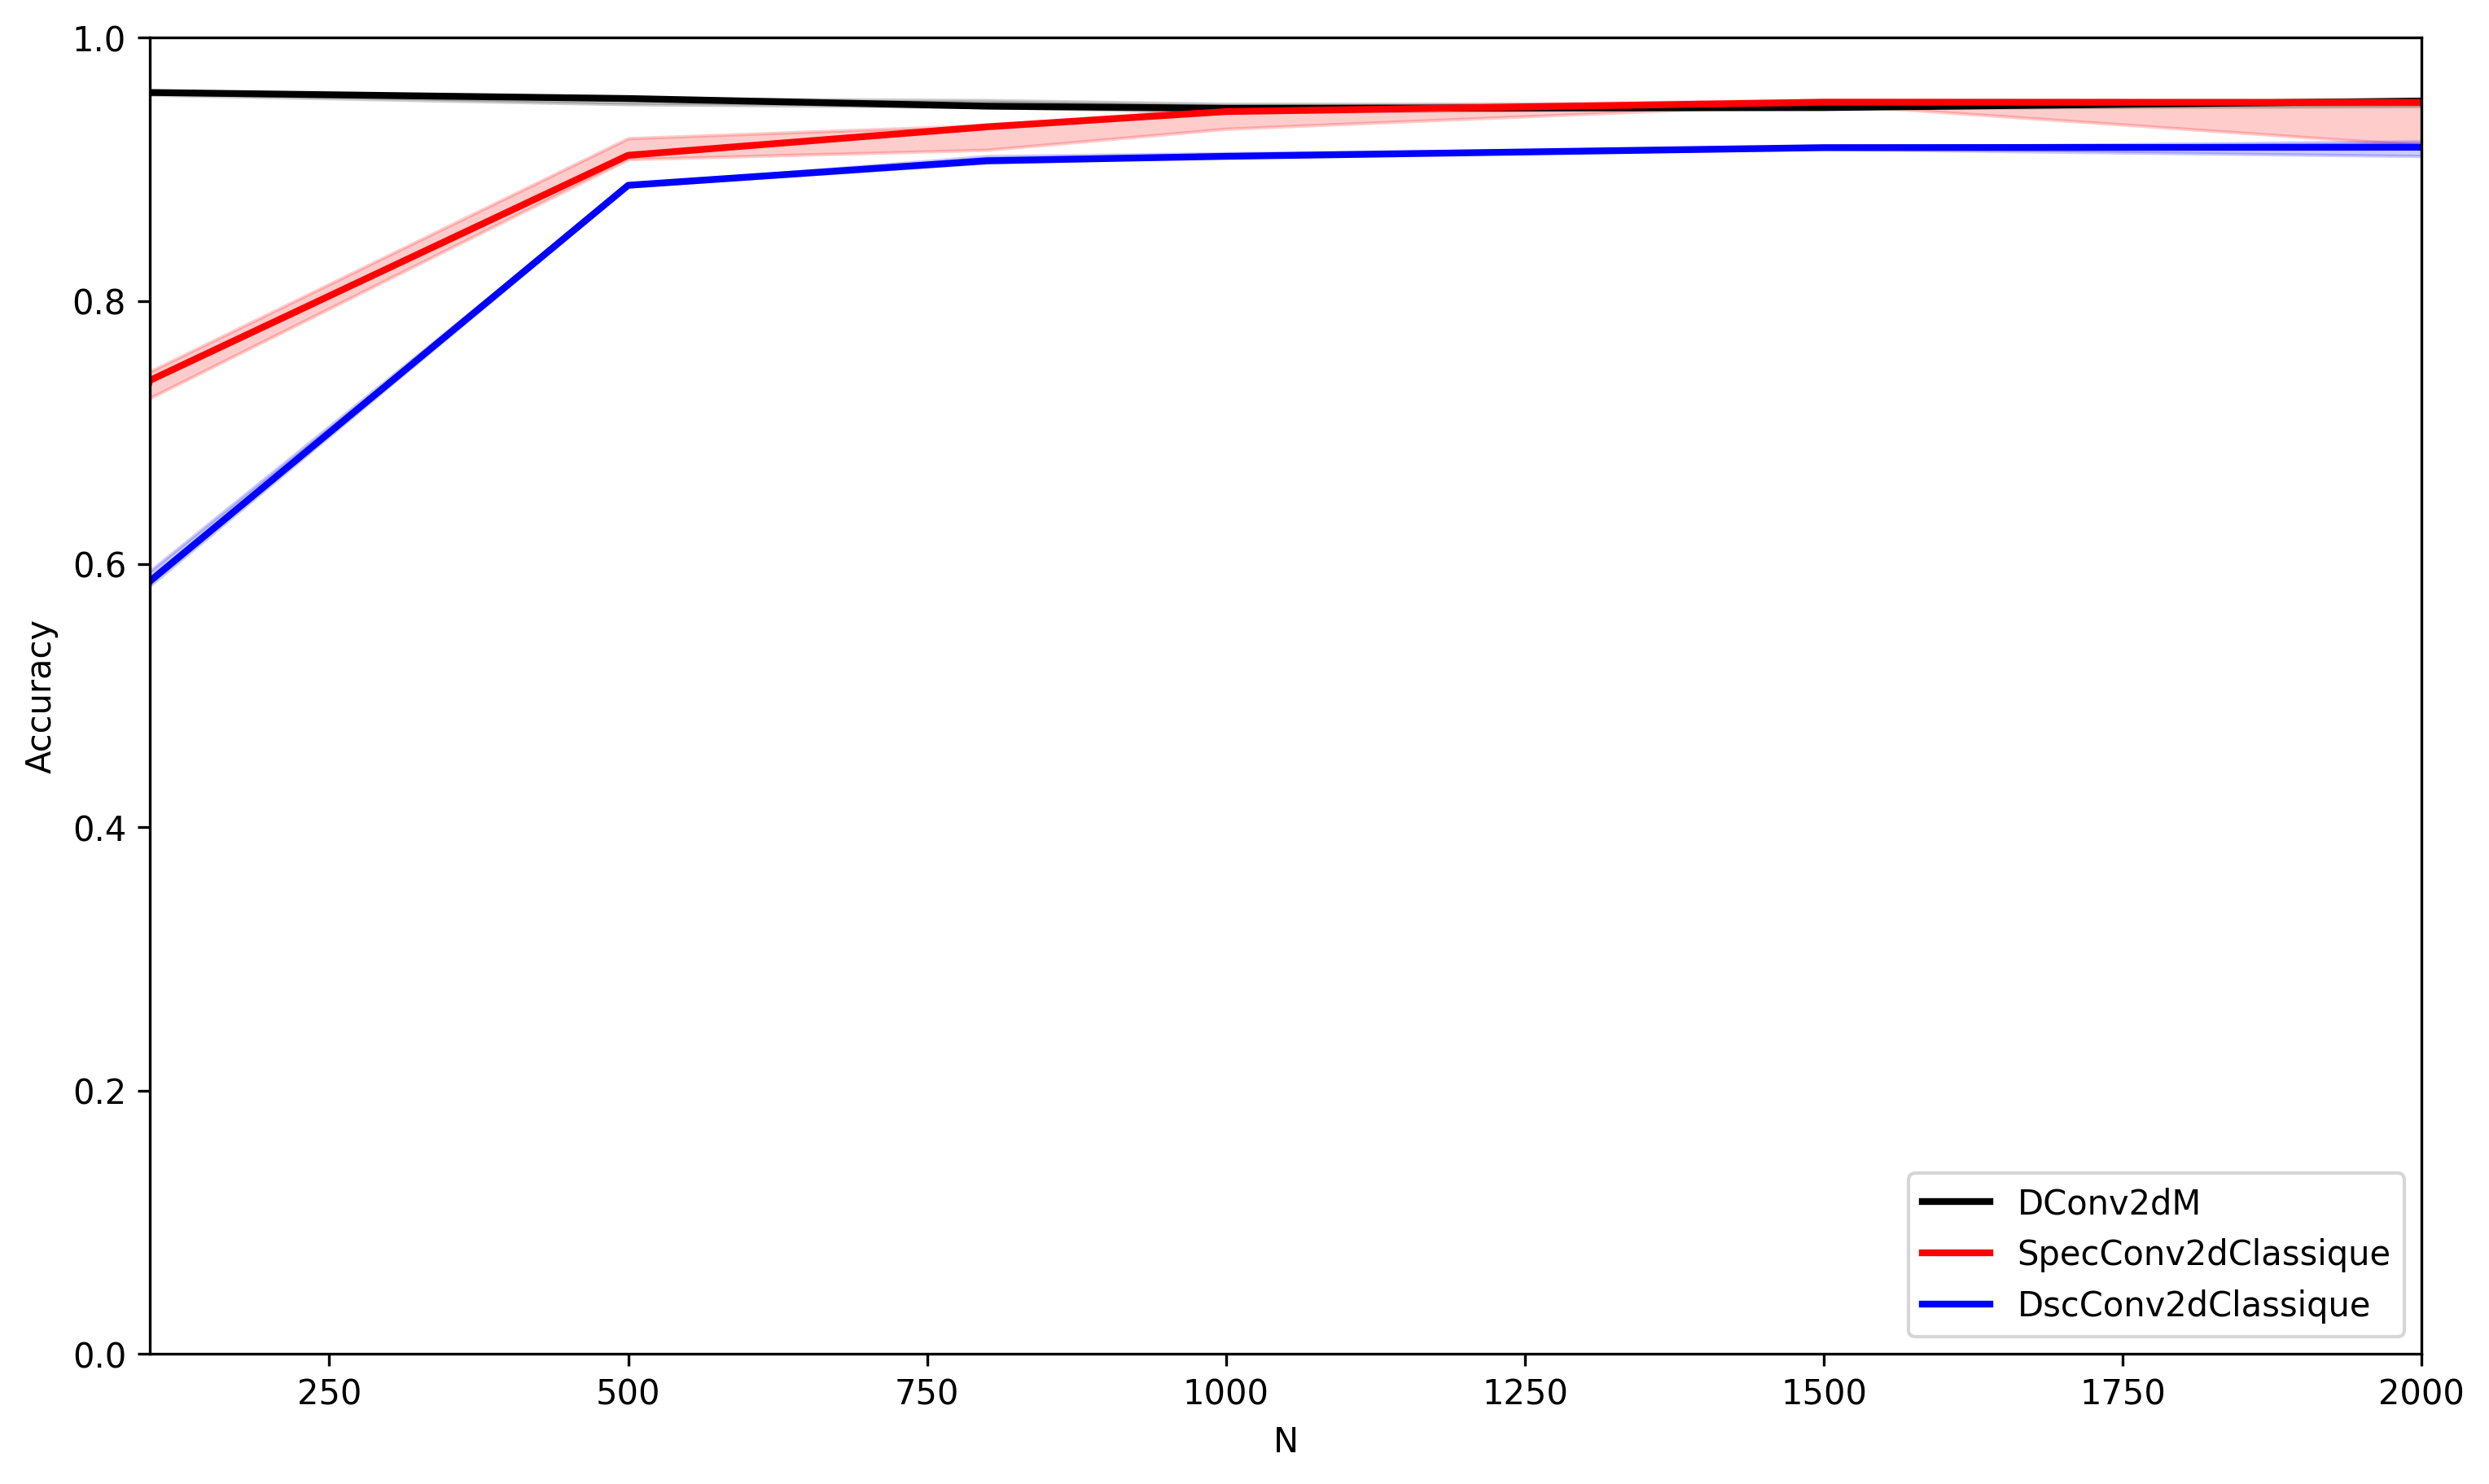

In [104]:
fig, ax = plt.subplots(num=1,figsize=(12,7),dpi=300)

ax.axis([100, 2000, 0, 1])

ax.plot(data9.index, data9.med, lw=2, label='DConv2dM', color="k")
ax.plot(data12.index, data12.med, lw=2, label='SpecConv2dClassique', color="r")
ax.plot(data13.index, data13.med, lw=2, label='DscConv2dClassique', color="b")

ax.fill_between(data9.index,data9.q1,data9.q2, color='k', alpha=0.2)
ax.fill_between(data12.index,data12.q1,data12.q2, color='r', alpha=0.2)
ax.fill_between(data13.index,data13.q1,data13.q2, color='b', alpha=0.2)

ax.legend(loc='lower right')
ax.set_xlabel('N')
ax.set_ylabel('Accuracy')

In [105]:
data14=extract_accuracy_and_save(name_file="SpecConv2dDiagUseDecode",i=2)
data14["q1"]=data14[["r1",'r2',"r3","r4","r5"]].quantile(0.25,axis=1)
data14["q2"]=data14[["r1",'r2',"r3","r4","r5"]].quantile(0.75,axis=1)
data14["med"]=data14[["r1",'r2',"r3","r4","r5"]].median(axis=1)
data14

,r1,r2,r3,r4,r5,vmax,vmin,vmean,sigma,q1,q2,med
N,,,,,,,,,,,,
20,0.8033,0.8261,0.8039,0.7877,0.8375,0.8375,0.7877,0.811957,0.019877,0.8033,0.8261,0.8039
80,0.8823,0.8612,0.8508,0.8646,0.8892,0.8892,0.8508,0.869729,0.015767,0.8612,0.8823,0.8646
100,0.8663,0.8956,0.8818,0.8813,0.8878,0.8956,0.8663,0.882100,0.010771,0.8813,0.8878,0.8818
500,0.9148,0.9185,0.9252,0.9227,0.9188,0.9252,0.9148,0.920000,0.004033,0.9185,0.9227,0.9188
800,0.9324,0.9320,0.9316,0.9318,0.9372,0.9372,0.9316,0.933400,0.002366,0.9318,0.9324,0.9320
1000,0.9195,0.9254,0.9282,0.9257,0.9344,0.9344,0.9195,0.926729,0.005386,0.9254,0.9282,0.9257
1500,0.9359,0.9345,0.9312,0.9364,0.9374,0.9374,0.9312,0.934857,0.002408,0.9345,0.9364,0.9359
2000,0.9332,0.9378,0.9440,0.9343,0.9245,0.9440,0.9245,0.934614,0.007116,0.9332,0.9378,0.9343


In [106]:
data15=extract_accuracy_and_save(name_file="SpecConv2dDiagUseDecodeEncode",i=2)
data15["q1"]=data15[["r1",'r2',"r3","r4","r5"]].quantile(0.25,axis=1)
data15["q2"]=data15[["r1",'r2',"r3","r4","r5"]].quantile(0.75,axis=1)
data15["med"]=data15[["r1",'r2',"r3","r4","r5"]].median(axis=1)
data15

,r1,r2,r3,r4,r5,vmax,vmin,vmean,sigma,q1,q2,med
N,,,,,,,,,,,,
20,0.8386,0.8519,0.8485,0.8606,0.8485,0.8606,0.8386,0.849614,0.007901,0.8485,0.8519,0.8485
80,0.9012,0.9020,0.8887,0.9095,0.9017,0.9095,0.8887,0.900186,0.007489,0.9012,0.9020,0.9017
100,0.8961,0.9025,0.9007,0.8994,0.9051,0.9051,0.8961,0.900714,0.003370,0.8994,0.9025,0.9007
500,0.9309,0.9353,0.9307,0.9282,0.9337,0.9353,0.9282,0.931757,0.002776,0.9307,0.9337,0.9309
800,0.9356,0.9314,0.9407,0.9393,0.9342,0.9407,0.9314,0.936186,0.003783,0.9342,0.9393,0.9356
1000,0.9390,0.9374,0.9412,0.9363,0.9349,0.9412,0.9349,0.937843,0.002440,0.9363,0.9390,0.9374
1500,0.9391,0.9428,0.9384,0.9437,0.9336,0.9437,0.9336,0.939271,0.004022,0.9384,0.9428,0.9391
2000,0.9402,0.9427,0.9396,0.9462,0.9429,0.9462,0.9396,0.942486,0.002619,0.9402,0.9429,0.9427


## Effet encode decode

Text(0, 0.5, 'Accuracy')

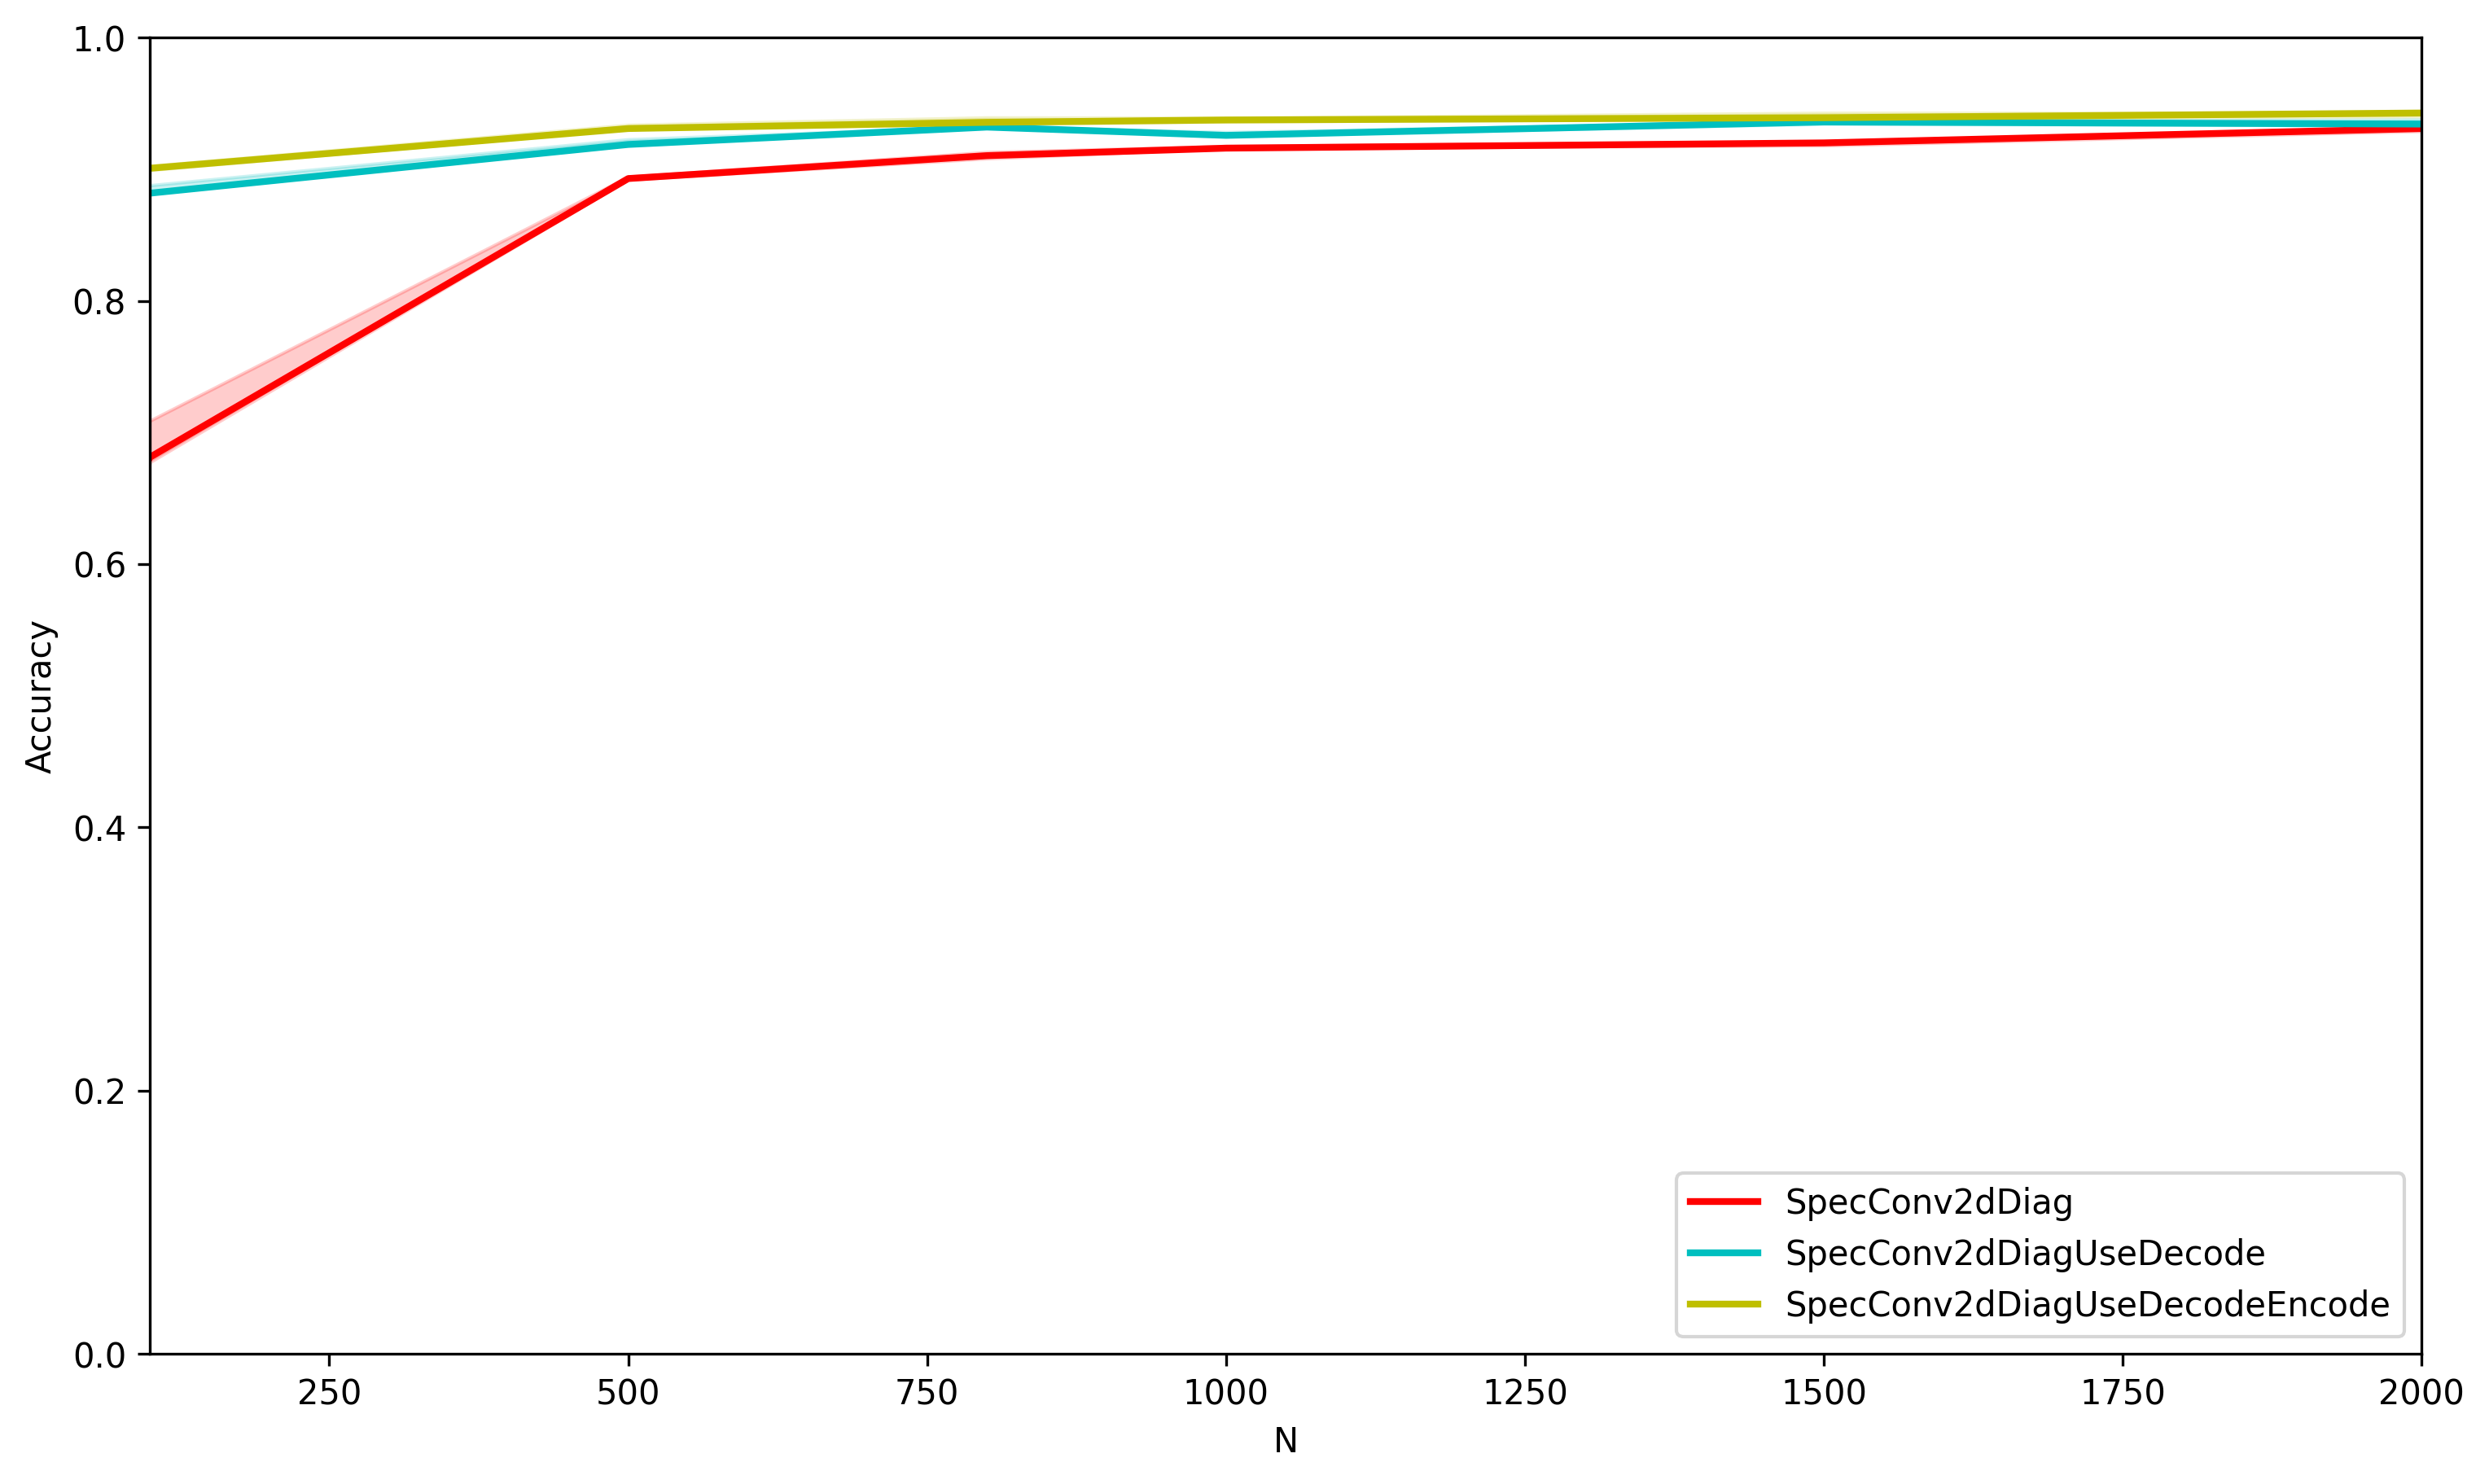

In [107]:
fig, ax = plt.subplots(num=1,figsize=(12,7),dpi=300)

ax.axis([100, 2000, 0, 1])

ax.plot(data10.index, data10.med, lw=2, label='SpecConv2dDiag', color="r")
ax.plot(data14.index, data14.med, lw=2, label='SpecConv2dDiagUseDecode', color="c")
ax.plot(data15.index, data15.med, lw=2, label='SpecConv2dDiagUseDecodeEncode', color="y")

ax.fill_between(data10.index,data10.q1,data10.q2, color='r', alpha=0.2)
ax.fill_between(data14.index,data14.q1,data14.q2, color='c', alpha=0.2)
ax.fill_between(data15.index,data15.q1,data15.q2, color='y', alpha=0.2)

ax.legend(loc='lower right')
ax.set_xlabel('N')
ax.set_ylabel('Accuracy')